<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Evaluation of text-based salience maps using Single Deletion

This notebook demonstrates how to use the Single Deletion metric implemented under `metrics` on text. Single deletion computes the model scores of perturbed instances by deleting a single attribute per instance.  <br> The user can then retrieve the relevant scores and use these for visualization purposes or computing their own metrics. This tutorial will use the spearman correlation and mean absolute error. <br>
<br>
More details about this method can be found in the paper, which inspired this implementation: https://arxiv.org/pdf/1806.07538.pdf.

### Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import spacy
from torchtext.vocab import Vectors
from scipy.special import expit as sigmoid
from metrics import Single_deletion

import dianna
from dianna.utils.tokenizers import SpacyTokenizer
from dianna import visualization

/home/willem/Documents/Thesis/dianna-exploration/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-30 14:12:32.379172: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 14:12:32.425811: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 14:12:32.426841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 14:12:33.109082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Defining labels and paths and getting the appropriate tokenizer.

In [37]:
model_path = Path().absolute().parent / 'models/movie_review_model.onnx'
word_vector_path = Path().absolute().parent / 'data/movie_reviews_word_vectors.txt'
labels = ("negative", "positive")

In [3]:
spacy.cli.download('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 21.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


#### 1 - Creating a callable model

We load in the Movie Reviews model, keep in mind that tokenization has to appear during evaluation and therefore needs to be excluded during model inference. The following class can be used that makes the movie review model callable and detects if input requires tokenization. 

In [4]:
class MovieReviewsModelRunner:
    def __init__(self, model, word_vectors, max_filter_size):
        self.run_model = dianna.utils.get_function(model)
        self.vocab = Vectors(word_vectors, cache=os.path.dirname(word_vectors))
        self.max_filter_size = max_filter_size
        
        self.tokenizer = SpacyTokenizer(name='en_core_web_sm')

    def __call__(self, sentences):
        output = []
        # ensure the input has a batch axis
        if isinstance(sentences, str):
            sentences = [sentences]

        for sentence in sentences:
            if isinstance(sentence, str):
                # tokenize and pad to minimum length
                tokens = self.tokenizer.tokenize(sentence)
                if len(tokens) < self.max_filter_size:
                    tokens += ['<pad>'] * (self.max_filter_size - len(tokens))
                
                # numericalize the tokens
                tokens_numerical = [self.vocab.stoi[token] if token in self.vocab.stoi else self.vocab.stoi['<unk>']
                                    for token in tokens]
            else: 
                tokens_numerical = sentence
            # run the model, applying a sigmoid because the model outputs logits, remove any remaining batch axis
            pred = float(sigmoid(self.run_model([tokens_numerical])))
            output.append(pred)

        # output two classes
        positivity = np.array(output)
        negativity = 1 - positivity
        return np.transpose([negativity, positivity])

In [5]:
# define model runner. max_filter_size is a property of the model

deleter = Single_deletion(model_runner, model_runner.tokenizer.tokenize, word_vector_path, max_filter_size=5)

#### 2 - Obtaining and Visualizing salient scores

Using dianna we obtain salience scores for LIME and RISE for the movie review listed below. 
    We further leverage DIANNA to highlit these relevances in text. 

In [6]:
model_runner = MovieReviewsModelRunner(model_path, word_vector_path, max_filter_size=5)
review = "The movie started out great but the ending was disappointing."

salience_RISE = dianna.explain_text(model_runner, review, model_runner.tokenizer, 'RISE',
                                                labels=[labels.index('positive')])[0]
salience_LIME = dianna.explain_text(model_runner, review, model_runner.tokenizer, 'LIME',
                                                labels=[labels.index('positive')])[0]


Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


In [7]:
print('RISE:')
visualization.highlight_text(salience_RISE, model_runner.tokenizer.tokenize(review))
print('LIME:')
visualization.highlight_text(salience_LIME, model_runner.tokenizer.tokenize(review))

RISE:


LIME:


#### 3 - Evaluating the salient scores 

We visualize our evaluation from the deleter below alongside with correlations and error metrics. 

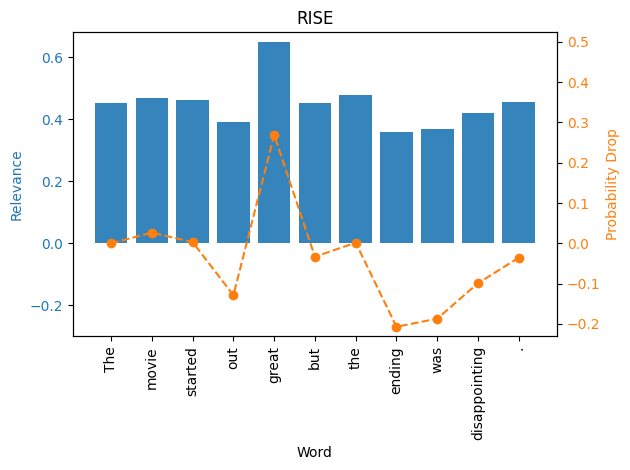

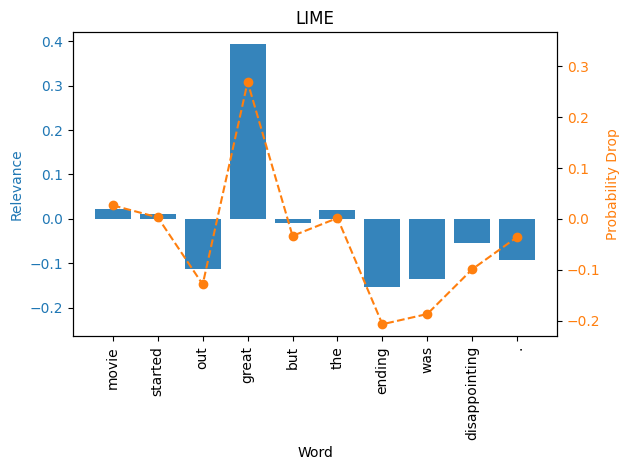

In [36]:
scores_RISE, _ = deleter.evaluate(salience_RISE, review)
scores_LIME, init_score = deleter.evaluate(salience_LIME, review)

probability_RISE = scores_RISE - init_score
probability_LIME = scores_LIME - init_score

deleter.visualize(salience_RISE, probability_RISE, title='RISE')
_ = deleter.visualize(salience_LIME, probability_LIME, title='LIME')

We also show our results in terms of concrete metrics consisting of the Spearman correlation and mean absolute error given by the probability drops with the salient scores.

In [ ]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error as MAE

_, _, relevance_RISE = deleter.sort_salience_map(salience_RISE)
_, _, relevance_LIME = deleter.sort_salience_map(salience_LIME)

corr = spearmanr(relevance_RISE, probability_RISE)
err = MAE(relevance_RISE, probability_RISE)
print('Metrics for RISE:')
print("Correlation Coefficient: {:.3f}, Signifcance: {:.10f}".format(*corr))
print("Mean Absolute Error: {:.3f}".format(err))

print()

corr = spearmanr(relevance_LIME, probability_LIME)
err = MAE(relevance_LIME, probability_LIME)
print('Metrics for LIME')
print("Correlation Coefficient: {:.3f}, Signifcance: {:.10f}".format(*corr))
print("Mean Absolute Error: {:.3f}".format(err))

Metrics for RISE:
Correlation Coefficient: 0.945, Signifcance: 0.0000111830
Mean Absolute Error: 0.486

Metrics for LIME
Correlation Coefficient: 0.976, Signifcance: 0.0000014675
Mean Absolute Error: 0.040


### 4 - Conclusions
We conclude that both RISE and LIME exhibit good correlation and therefore good correctness of relevances. However, we also observe that RISE operates on a different scale, unrepresentative of the probability drops per feature. As such, intelligibility might be impeded as can be deduced from the relatively high mean absolute error. LIME does not have this issue. 